In [95]:
# Exercise 9
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def dsprint(ds, num=1):
  # print(len(ds))
  for item in ds.take(num):
    print(item)

def draw_sketch(sketch, label=None):
  origin = np.array([[0., 0., 0.]])
  sketch = np.r_[origin, sketch]
  stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
  coordinates = np.cumsum(sketch[:, :2], axis=0)
  strokes = np.split(coordinates, stroke_end_indices + 1)
  plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
  for stroke in strokes:
      plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
  plt.axis("off")

def draw_sketches(sketches, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, label in zip(range(n_sketches), sketches, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:len(sketch)], label)
    plt.show()

In [108]:
class_map = {}
# create sketch rnn dataset
data_dir = os.path.join('../', 'data', 'quickdraw-full')
filenames = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
class_count = len(filenames)

for i in range(class_count):
  class_map[filenames[i]] = i


def create_dataset(filename, set_type):
  np_ds = np.load(str(filename), encoding='latin1', allow_pickle=True)[set_type]
  return tf.data.Dataset.from_generator(lambda: np_ds, tf.int16).map(lambda X: (X, class_map[str(filename)]))

def load_data(filenames, batch_size=32, set_type='train'):
  ds_list = [create_dataset(file, set_type) for file in filenames]
  ds = tf.data.Dataset.from_tensor_slices(ds_list)
  ds = ds.interleave(
    lambda x: x,
    cycle_length=len(filenames),
    block_length=1,
  )

  # ds = ds.shuffle(len(ds_list) * 10).map(lambda X, label: (tf.reverse(X, [1]), label)).padded_batch(batch_size, padded_shapes=([None, 3], ()))
  # return ds.map(lambda X, label: (tf.reverse(X, [1]), label))

  # count = 0
  # for item in ds:
  #   count += 1
  
  return ds.shuffle(len(filenames) * 10).padded_batch(batch_size, padded_shapes=([None, 3], ()))
  # return ds.padded_batch(batch_size, padded_shapes=([None, 3], ()))
  # return ds

In [111]:
train = load_data(filenames, set_type='train')
val = load_data(filenames, set_type='valid')
test = load_data(filenames, set_type='test')

In [114]:
traint = train.take(800)
valt = val.take(100)
testt = test.take(100)

tf.Tensor(
[ 3  2 13 17 10 16  7 18 10  0  4 18 13 12 18 14 21 20  3 22 14 24 17  0
  2 12 21 18  7  3  1 19], shape=(32,), dtype=int32)


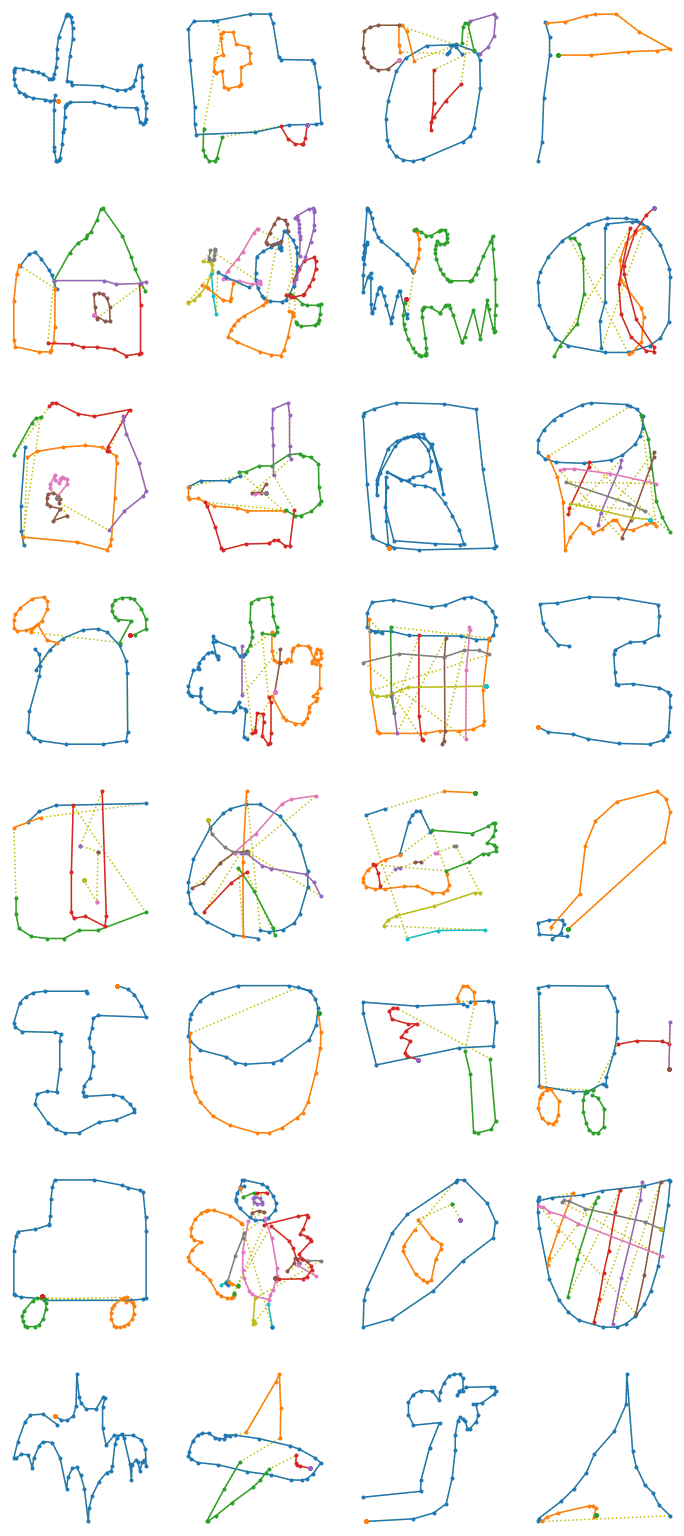

In [112]:
for item in train.take(1):
  # print(item[1], filenames[item[1].numpy()])
  # draw_sketch(item[0])
  print(item[1])
  draw_sketches(*item)

In [131]:
# model = keras.models.Sequential([
#   keras.layers.InputLayer(input_shape=[None, 3]),
#   keras.layers.BatchNormalization(),
#   keras.layers.Conv1D(20, kernel_size=4, strides=2),
#   keras.layers.BatchNormalization(),
#   keras.layers.Conv1D(20, kernel_size=4, strides=2),
#   keras.layers.BatchNormalization(),
#   keras.layers.LSTM(100, return_sequences=True),
#   keras.layers.LSTM(100, return_sequences=True),
#   keras.layers.LSTM(100, return_sequences=False),
#   keras.layers.Dense(class_count, activation='softmax'),
# ])

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 3]))
for dilation in [1, 2, 4, 8, 16, 32] * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=dilation))
model.add(keras.layers.LSTM(100, return_sequences=True))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())
model.add((keras.layers.Dense(class_count, activation='softmax')))

model.compile(
  loss=keras.losses.sparse_categorical_crossentropy,
  metrics=[keras.metrics.sparse_categorical_accuracy],
  optimizer=keras.optimizers.Nadam()
  # optimizer=keras.optimizers.SGD(0.001, 0.9, True)
)

# print(tf.argmax(model.predict(batch), axis=1))

model.fit(traint, validation_data=valt, epochs=20, callbacks=[
  # keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
  # keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=2),
])

Epoch 1/20
800/800 [==============================] - 55s 65ms/step - loss: 2.1409 - sparse_categorical_accuracy: 0.3387 - val_loss: 1.9409 - val_sparse_categorical_accuracy: 0.4288
Epoch 2/20
183/800 [=====>........................] - ETA: 37s - loss: 1.6705 - sparse_categorical_accuracy: 0.4773

KeyboardInterrupt: 

In [124]:
model.evaluate(testt)

100/100 [==============================] - 2s 16ms/step - loss: 0.7778 - sparse_categorical_accuracy: 0.7941


[0.7777690291404724, 0.7940624952316284]